# Succinic Acid Fermentation ODE Model

## 1. Setup and Environment

In [1]:
import sys
import platform
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
from pytensor.compile.ops import as_op
import arviz as az
import scipy
from scipy.integrate import odeint, solve_ivp
import sunode
import sunode.wrappers.as_pytensor

import multiprocessing as mp
mp.set_start_method('fork')

In [2]:
# Set random seed for reproducibility
np.random.seed(1234)

In [3]:
# Print system information
print("="*50)
print("System Information")
print("="*50)
print(f"Platform: {platform.platform()}")
print(f"Python version: {sys.version}")
print(f"Process start method: {mp.get_start_method()}")

# Print probabilistic programming stack versions
print("\n" + "="*50)
print("Probabilistic Programming Stack")
print("="*50)
print(f"PyMC version: {pm.__version__}")
print(f"PyTensor version: {pytensor.__version__}")
print(f"ArviZ version: {az.__version__}")

# Print ODE-related package versions
print("\n" + "="*50)
print("ODE Integration Packages")
print("="*50)
print(f"odeint version: Part of SciPy {scipy.__version__}")
print(f"solve_ivp version: Part of SciPy {scipy.__version__}")
print(f"sunode version: {sunode.__version__}")

System Information
Platform: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
Python version: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
Process start method: fork

Probabilistic Programming Stack
PyMC version: 5.22.0
PyTensor version: 2.30.3
ArviZ version: 0.21.0

ODE Integration Packages
odeint version: Part of SciPy 1.15.2
solve_ivp version: Part of SciPy 1.15.2
sunode version: 0.6.0


## 2. Model Configuration

In [4]:
# Data from Run 1 (Table 1)
# Initial values
CXt0 = 0.05  # g/L (Biomass concentration)
CSt0 = 40.0  # g/L (Glucose concentration)
CPt0 = 0.0   # g/L (Succinic Acid - starting at zero)
CBPt0 = 0.0  # g/L (By-Products - starting at zero)

# Parameters from Run 1 (Table 2)
Cxm = 5.02   # g/L
KP1 = 0.007  # L/g/h
KP2 = 0.019  # L/g/h
mu = 0.85    # 1/h
YS_P1 = 0.24 # g/g
YS_P2 = 2.27 # g/g
YS_BP = 1.10 # g/g
YS_X = 1.65  # g/g

# Generate time points
times = np.arange(0.0, 35.0, 0.01)  # 35 hours of fermentation with 0.01h resolution
params = [Cxm, KP1, KP2, mu, YS_P1, YS_P2, YS_BP, YS_X]
initial_conditions = [CXt0, CSt0, CPt0, CBPt0]

## 3. ODE Solver Comparison

SciPy features two different interfaces to solve differential equations: odeint and solve_ivp. The newer one is solve_ivp and it is recommended but odeint is still widespread, probably because of its simplicity. The primary advantage is that solve_ivp offers several methods for solving differential equations whereas odeint is restricted to one (LSODA).

### 3.1 SciPy's odeint

In [5]:
# Define the right hand side of the ODE equations using Numba for acceleration
# Numba's @njit decorator compiles the function to machine code for faster execution.
from numba import njit

@njit
def scipy_rhs(X, t, params):
    # Unpack state variables
    CX, CS, CP, CBP = X

    # Unpack parameters
    Cxm, KP1, KP2, mu, YS_P1, YS_P2, YS_BP, YS_X = params

    # Calculate reaction rates (Equations 4-6)
    r1 = mu * CX * (1 - CX / Cxm)
    r2 = KP1 * CS * CX
    r3 = KP2 * CS * CX

    # Calculate production and consumption rates (Equations 7-10)
    dCS_dt = -YS_X * r1 - YS_P1 * r2 - YS_P2 * r3
    dCP_dt = r2
    dCX_dt = r1
    dCBP_dt = YS_BP * r2 + r3

    return [dCX_dt, dCS_dt, dCP_dt, dCBP_dt]

In [6]:
# Solve ODE using odeint (LSODA algorithm: automatic stiff/non-stiff detection)
print("\nRunning odeint...")
start_time = time.time()
    
solution_odeint = odeint(
    func=scipy_rhs,
    y0=initial_conditions,
    t=times,
    args=(params,),
)

odeint_time = time.time() - start_time
print(f"odeint completed in {odeint_time:.4f} seconds")


Running odeint...
odeint completed in 0.1296 seconds


### 3.2 SciPy's solve_ivp

In [7]:
# Solve ODE using solve_ivp (BDF method)
print("\nRunning solve_ivp...")
start_time = time.time()

solution_solve_ivp = solve_ivp(
    fun=lambda t, y: scipy_rhs(y, t, params),  # Wrapped to match solve_ivp's t-first signature
    y0=np.array(initial_conditions, dtype=np.float64),
    t_span=(times[0], times[-1]),
    t_eval=times,  # Ensure solution is returned at identical time points
    method='BDF',  # Best for stiff systems
    rtol=1e-6,
    atol=1e-6
)

solve_ivp_time = time.time() - start_time
print(f"solve_ivp completed in {solve_ivp_time:.4f} seconds")


Running solve_ivp...
solve_ivp completed in 0.1403 seconds


### 3.3 sunode

Sunode wraps the sundials solvers ADAMS and BDF, and their support for solving adjoint ODEs in order to compute gradients of the solutions. The required right-hand-side function and some derivatives are either supplied manually or via sympy, in which case sunode will generate the abstract syntax tree of the functions using symbolic differentiation and common subexpression elimination. In either case the functions are compiled using numba and the resulting C-function is passed to sunode, so that there is no python overhead.

sunode comes with an PyTensor wrapper so that parameters of an ODE can be estimated using PyMC.

In [8]:
# If we want to solve this ODE without the support of PyTensor or PyMC, 
# we need to first declare the parameters and states we are using. 

# System parameters
params = {'Cxm': (), 'KP1': (), 'KP2': (), 'mu': (), 'YS_P1': (), 'YS_P2': (), 'YS_BP': (), 'YS_X': ()}
# State variables
states = {'CX': (), 'CS': (), 'CP': (), 'CBP': ()}

# Define the ODE system using symbolic formulation (required by sunode)
def sunode_rhs(t, y, p):
    # Reaction rate equations
    r1 = p.mu * y.CX * (1 - y.CX / p.Cxm)
    r2 = p.KP1 * y.CS * y.CX
    r3 = p.KP2 * y.CS * y.CX

    return {
        'CX': r1,
        'CS': -p.YS_X * r1 - p.YS_P1 * r2 - p.YS_P2 * r3,
        'CP': r2,
        'CBP': p.YS_BP * r2 + r3
    }

# Create a SympyProblem instance
problem = sunode.SympyProblem(
    params=params,
    states=states,
    rhs_sympy=sunode_rhs,
    # We need to specify with respect to which variables gradients should be computed.
    derivative_params=(),
)

# Initialize solver with BDF method 
solver = sunode.solver.Solver(problem=problem, solver='BDF')
# solver = sunode.solver.Solver(problem=problem, solver='ADAMS')

In [9]:
# Create structured array for initial conditions
# We can use numpy structured arrays as input, so that we don't need to think about how the different variables are stored in the array.
# This does not introduce any runtime overhead during solving.
y0 = np.zeros((), dtype=problem.state_dtype)
y0['CX'] = 0.05
y0['CS'] = 40.0
y0['CP'] = 0.0
y0['CBP'] = 0.0

params_values = {
    'Cxm': 5.02, 
    'KP1': 0.007, 
    'KP2': 0.019,
    'mu': 0.85, 
    'YS_P1': 0.24, 
    'YS_P2': 2.27,
    'YS_BP': 1.10, 
    'YS_X': 1.65
}

# Set parameter values
solver.set_params_dict(params_values)

output = solver.make_output_buffers(times)

print("\nRunning sunode...")
start_time = time.time()
solution_sunode = solver.solve(t0=0, tvals=times, y0=y0, y_out=output)

solve_sunode_time = time.time() - start_time
print(f"sunode completed in {solve_sunode_time:.4f} seconds")


Running sunode...
sunode completed in 0.0042 seconds


In [10]:
# plot model function
def plot_model(times, sol):
    """Plot ODE solution results"""
    variables = ["Biomass (X)", "Glucose (G)", "Succinic Acid (SA)", "By-Products (BP)"]
    colors = ["green", "blue", "red", "orange"]
    
    for i in range(4):
        plt.plot(times, sol[:, i], label=variables[i], color=colors[i])

    plt.xlabel("Time (h)")
    plt.ylabel("Concentration (g/L)")
    plt.legend()
    plt.tight_layout()
    plt.show()

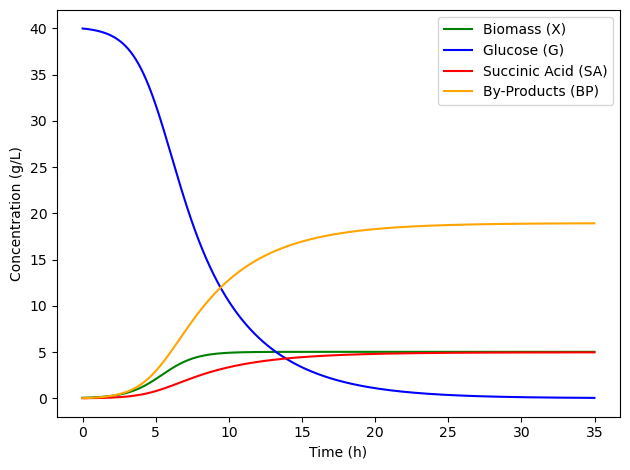

In [11]:
plot_model(times=times, sol=solution_odeint)

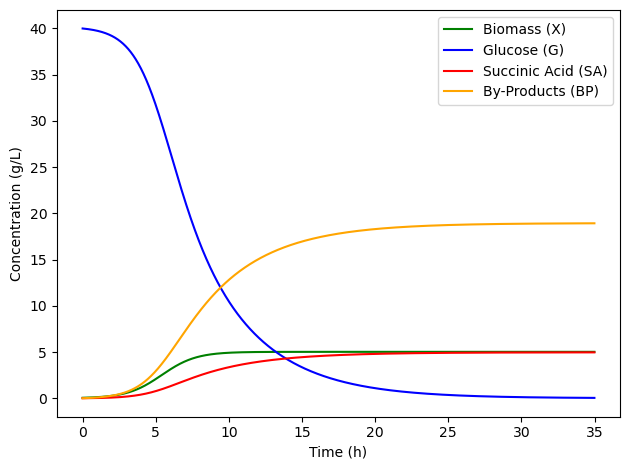

In [12]:
plot_model(times=times, sol=solution_solve_ivp.y.T)

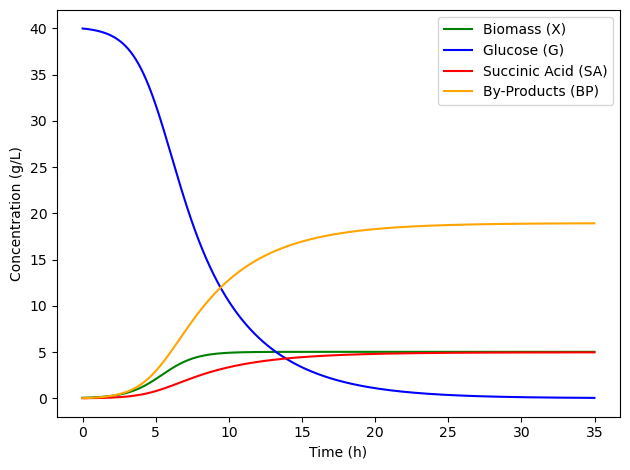

In [13]:
# Convert to xarray for convenient plotting
output_sunode = solver.as_xarray(times, output)
sol_array = np.stack([output_sunode['solution_CX'].values, output_sunode['solution_CS'].values, output_sunode['solution_CP'].values, output_sunode['solution_CBP'].values], axis=1)
plot_model(times=times, sol=sol_array)

## 4. Experimental Data Simulation

In [14]:
from scipy.stats import norm, lognorm, poisson

def add_noise(data, noise_type='gaussian', **kwargs):
    """Add different types of measurement noise to the data"""
    noisy_data = data.copy()
    n_points = len(data)

    if noise_type == 'gaussian':
        # Gaussian noise (good for general continuous measurements)
        scale = kwargs.get('scale', 0.05)  # Default 5% noise
        noise = norm.rvs(scale=scale*np.abs(data), size=n_points)
        noisy_data += noise
    
    elif noise_type == 'lognormal':
        # Log-normal noise (for strictly positive quantities with large dynamic range)
        sigma = kwargs.get('sigma', 0.1)  # Shape parameter
        noise = lognorm.rvs(s=sigma, scale=np.abs(data)) - data
        noisy_data += noise
    
    elif noise_type == 'poisson':
        # Poisson noise (for counting processes like cell counting)
        noisy_data = poisson.rvs(np.abs(data)*kwargs.get('scale', 100)) / kwargs.get('scale', 100)
    
    elif noise_type == 'dropout':
        # Random missing data (simulate failed measurements)
        dropout_prob = kwargs.get('prob', 0.05)  # 5% dropout rate
        mask = np.random.rand(n_points) > dropout_prob
        noisy_data[~mask] = np.nan
    
    return noisy_data

In [15]:
def simulate_experiment(n_samples=35, noise_configs=None, random_seed=42):
    """Generate realistic experimental data with:
    - Sparse time sampling
    - Multiple noise types per variable
    """
    np.random.seed(random_seed)

    # Generate time points
    tvals = np.arange(n_samples)

    # Interpolate ODE solution to get exact hourly values
    from scipy.interpolate import interp1d
    def interpolate(var_name):
        f = interp1d(times, output_sunode[f'solution_{var_name}'], kind='cubic', fill_value="extrapolate")
        return f(tvals)

    clean_data = {
        'time': tvals,
        'Biomass (X)': interpolate('CX'),
        'Glucose (G)': interpolate('CS'),
        'Succinic Acid (SA)': interpolate('CP'),
        'By-Products (BP)': interpolate('CBP')
    }

    # Default noise configurations if not provided
    if noise_configs is None:
        noise_configs = {
            'Biomass (X)': {'noise_type': 'gaussian', 'scale': 0.12},  # 12% noise for biomass
            'Glucose (G)': {'noise_type': 'lognormal', 'sigma': 0.25},  # Log-normal for substrate
            'Succinic Acid (SA)': {'noise_type': 'gaussian', 'scale': 0.15},  # 15% noise for product
            'By-Products (BP)': {'noise_type': 'gaussian', 'scale': 0.10}  # 10% noise for by-product
        }
    
    # Add noise to each variable according to config
    noisy_data = {'time': tvals}
    for var in ['Biomass (X)', 'Glucose (G)', 'Succinic Acid (SA)', 'By-Products (BP)']:
        noisy_data[var] = add_noise(clean_data[var], **noise_configs.get(var, {}))
    
    return pd.DataFrame(noisy_data), pd.DataFrame(clean_data)

In [16]:
# Generate data
experiment_data, model_data = simulate_experiment(n_samples=35, random_seed=42)

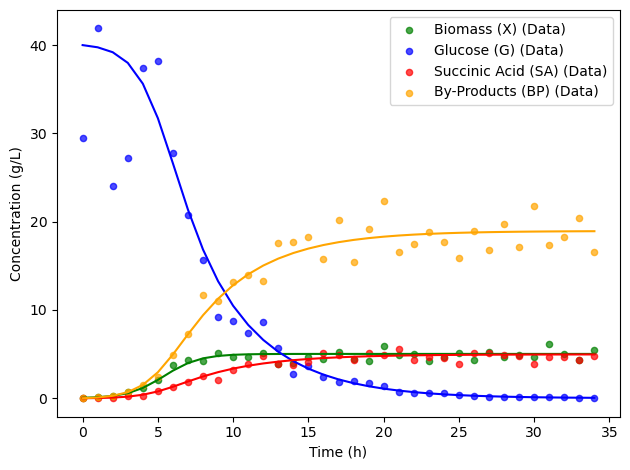

In [17]:
variables = ['Biomass (X)', 'Glucose (G)', 'Succinic Acid (SA)', 'By-Products (BP)']
colors = ["green", "blue", "red", "orange"]

for i, var in enumerate(variables):
    # Plot model data
    plt.plot(model_data['time'], model_data[var], color=colors[i], linestyle='-')
    # Plot experimental data
    plt.scatter(experiment_data['time'], experiment_data[var], color=colors[i], marker='o', s=20, alpha=0.7, label=f'{var} (Data)')

plt.xlabel("Time (h)")
plt.ylabel("Concentration (g/L)")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Bayesian Parameter Estimation

In [18]:
import sunode.wrappers.as_pytensor
from sunode.wrappers.as_pytensor import solve_ivp

with pm.Model() as model:
    # ======== PRIORS FOR MODEL PARAMETERS ========

    Cxm = pm.TruncatedNormal('Cxm', mu=5.02, sigma=1.0, lower=2.0, upper=8.0)  # Truncated to prevent biologically implausible values
    KP1 = pm.Lognormal('KP1', mu=np.log(0.007), sigma=0.3)  # Ensures parameters are positive and allows for right-skewed uncertainty (common for rates)
    KP2 = pm.Lognormal('KP2', mu=np.log(0.019), sigma=0.4)
    mu = pm.Gamma('mu', alpha=2, beta=2, default_transform=None)  # Gamma is commonly used for strictly positive rates; shape ~ moderately skewed
    YS_P1 = pm.TruncatedNormal('YS_P1', mu=0.24, sigma=0.1, lower=0.01, upper=0.5)
    YS_P2 = pm.TruncatedNormal('YS_P2', mu=2.27, sigma=0.5, lower=1.0, upper=4.0)
    YS_BP = pm.TruncatedNormal('YS_BP', mu=1.10, sigma=0.1, lower=0.5, upper=2.0)
    YS_X = pm.TruncatedNormal('YS_X', mu=1.65, sigma=0.2, lower=0.5, upper=3.0)

    # ======== SOLVING ODEs USING SUNODE ========
    
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
        # The initial conditions of the ODE. Each variable needs to specify a PyTensor or numpy variable and a shape.
        y0={
            'CX': (0.05, ()), 
            'CS': (40.0, ()), 
            'CP': (0.0, ()), 
            'CBP': (0.0, ())
        },
        # Each parameter of the ODE. sunode will only compute derivatives 
        # with respect to PyTensor variables. The shape needs to be specified as well.
        params={
            'Cxm': (Cxm, ()),
            'KP1': (KP1, ()),
            'KP2': (KP2, ()),
            'mu': (mu, ()),
            'YS_P1': (YS_P1, ()),
            'YS_P2': (YS_P2, ()),
            'YS_BP': (YS_BP, ()),
            'YS_X': (YS_X, ()),
            'extra': np.zeros(1),  # Placeholder for any additional parameters
        },
        # A function that computes the right-hand-side of the ODE using sympy variables.
        rhs=sunode_rhs,
        tvals=np.arange(35),  # The time points where we want to access the solution.
        t0=0
    )

    # ======== OBSERVATION NOISE MODELS (LIKELIHOOD) ========

    # Observation noise parameters - half-normal for positive-only standard deviations
    sigma_CX = pm.HalfNormal('sigma_CX', sigma=0.05)
    sigma_CS = pm.HalfNormal('sigma_CS', sigma=1.0)
    sigma_CP = pm.HalfNormal('sigma_CP', sigma=0.1)
    sigma_CBP = pm.HalfNormal('sigma_CBP', sigma=0.2)

    # We can access the individual variables of the solution using the variable names.
    # pm.Deterministic('CX_mu', y_hat['CX'])
    # pm.Deterministic('CS_mu', y_hat['CS'])
    # pm.Deterministic('CP_mu', y_hat['CP'])
    # pm.Deterministic('CBP_mu', y_hat['CBP'])

    # Likelihood functions
    pm.Normal('CX_obs', mu=y_hat['CX'], sigma=sigma_CX, observed=experiment_data['Biomass (X)'])
    pm.Normal('CS_obs', mu=y_hat['CS'], sigma=sigma_CS, observed=experiment_data['Glucose (G)'])
    pm.Normal('CP_obs', mu=y_hat['CP'], sigma=sigma_CP, observed=experiment_data['Succinic Acid (SA)'])
    pm.Normal('CBP_obs', mu=y_hat['CBP'], sigma=sigma_CBP, observed=experiment_data['By-Products (BP)'])

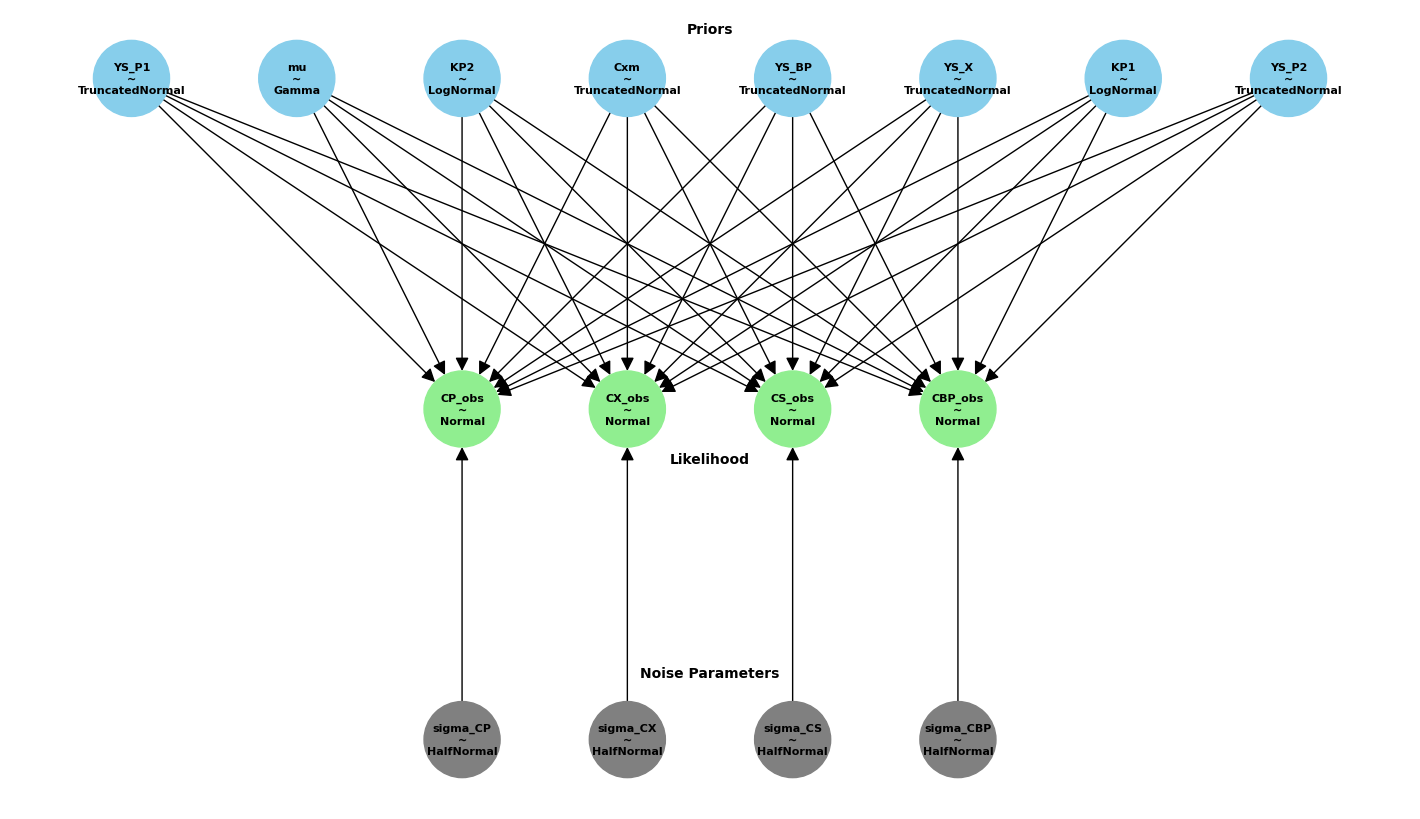

In [19]:
import pygraphviz as pgv
import networkx as nx

# Function to generate centered horizontal positions for a list of nodes
def get_centered_positions(nodes, y_level, spacing=2):
    n = len(nodes)
    start_x = - (n - 1) * spacing / 2
    return {node: (start_x + i * spacing, y_level) for i, node in enumerate(nodes)}

# Generate Graphviz graph from PyMC model
graph = pm.model_to_graphviz(model)
pgv_graph = pgv.AGraph(string=str(graph))  # Convert Graphviz graph to PyGraphviz format
nx_graph = nx.nx_agraph.from_agraph(pgv_graph)  # Convert PyGraphviz graph to NetworkX graph for plotting

# Extract node labels for display
node_labels = {}
for node in pgv_graph.nodes():
    name = node.get_name()
    label = node.attr.get('label', name)
    node_labels[name] = label

# Get all nodes and categorize them
all_nodes = list(nx_graph.nodes())
# Identify observation nodes (they end with _obs)
obs_nodes = [n for n in all_nodes if n.endswith('_obs')]
# Identify sigma nodes (they start with sigma_)
sigma_nodes = [n for n in all_nodes if n.startswith('sigma_')]
# The remaining nodes are priors (parameters)
prior_nodes = [n for n in all_nodes if n not in obs_nodes + sigma_nodes]

# Manually position nodes in three layers
pos = {}
spacing = 1.5  # Reduced spacing for tighter layout

# 1. Top layer: Priors (parameters) - horizontal layout
pos.update(get_centered_positions(prior_nodes, y_level=2, spacing=spacing))
# 2. Middle layer: Observation nodes - horizontal layout
obs_positions = get_centered_positions(obs_nodes, y_level=0, spacing=spacing)
pos.update(obs_positions)
# 3. Bottom layer: Sigma nodes - aligned with their observations
for sigma in sigma_nodes:
    # Extract the base name (e.g., 'CX' from 'sigma_CX')
    base_name = sigma.replace('sigma_', '')
    # Find the corresponding observation node
    # It could be either base_name + '_obs' or just base_name
    possible_obs_names = [f"{base_name}_obs", base_name]
    for obs_name in possible_obs_names:
        if obs_name in obs_positions:
            pos[sigma] = (obs_positions[obs_name][0], -2)  # Position at y=-2
            break

# Assign colors based on node type
node_colors = []
for node in nx_graph.nodes():
    if node.endswith('_obs'):
        node_colors.append('lightgreen')
    elif node.startswith('sigma_'):
        node_colors.append('gray')
    else:
        node_colors.append('skyblue')

# Draw the graph
plt.figure(figsize=(14, 8))
nx.draw(nx_graph, pos, labels=node_labels, with_labels=True, 
        node_size=3000, node_color=node_colors, 
        font_size=8, font_weight='bold', arrowsize=20)

plt.text(0, 2.3, "Priors", ha='center', va='center', fontsize=10, fontweight='bold')
plt.text(0, -0.3, "Likelihood", ha='center', va='center', fontsize=10, fontweight='bold')
plt.text(0, -1.6, "Noise Parameters", ha='center', va='center', fontsize=10, fontweight='bold')
plt.axis('off')
plt.show()

### 5.1 Bayesian Inference with Gradients

In [20]:
sampler = "NUTS"

import ipywidgets

with model:
    trace = pm.sample(draws=500, tune=500, chains=4, cores=4, random_seed=42, nuts_sampler_kwargs={"ode_config": {"atol": 1e-6, "rtol": 1e-6, "max_steps": 10000}})
az.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Cxm, KP1, KP2, mu, YS_P1, YS_P2, YS_BP, YS_X, sigma_CX, sigma_CS, sigma_CP, sigma_CBP]


Output()


[CVODES ERROR]  CVode
  At t = 0 repeated recoverable right-hand side function errors.


[CVODES ERROR]  CVode
  At t = 0 repeated recoverable right-hand side function errors.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  At t = 0 and h = 1.60834e-42, the error test failed repeatedly or with |h| = hmin.


[CVODES ERROR]  CVode
  At t = 0 and h = 1.60834e-42, the error test failed repeatedly or with |h| = hmin.


[CVODES ERROR]  CVode
  At t = 0 repeated recoverable right-hand side function errors.


[CVODES ERROR]  CVode
  At t = 0 repeated recoverable right-hand side function errors.


[CVODES ERROR]  CVode

[CVODES ERROR]  CVode

[CVODEA ERROR]  CVodeF
  At t = 1.53595e-08, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  At t = 0.00310883, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF

[CVODES ERROR]  CVod

  At t = 0.0157159, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.

  At t = 1.53595e-08, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  At t = 0.00310883, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF

[CVODEA ERROR]  CVodeF
  At t = 0 repeated recoverable right-hand side function errors.


[CVODES ERROR]  CVode
  At t = 0 repeated recoverable right-hand side function errors.

  At t = 0.0157159, mxstep steps taken before reaching tout.

  At t = 0 and h = 3.57076e-36, the error test failed repeatedly or with |h| = hmin.


[CVODES ERROR]  CVode
  At t = 0 and h = 3.57076e-36, the error test failed repeatedly or with |h| = hmin.


[CVODES ERROR]  CVode
  At t = 1.17031e-07, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  At t = 0 and h = 3.33574e-117, the corrector converge

  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 13.8938, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 13.6217, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 13.0621, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.415532, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0

  At t = 12.7438, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 12.2732, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward p

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 122 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.880,0.027,0.829,0.929,0.001,0.001,1739.0,1409.0,1.0
Cxm,4.828,0.063,4.717,4.951,0.001,0.001,2243.0,1389.0,1.0
KP1,0.007,0.000,0.006,0.008,0.000,0.000,1559.0,1389.0,1.0
KP2,0.020,0.001,0.018,0.023,0.000,0.000,1362.0,1157.0,1.0
YS_P1,0.238,0.097,0.043,0.405,0.002,0.002,2185.0,1035.0,1.0
YS_P2,2.338,0.123,2.123,2.582,0.003,0.003,1403.0,1380.0,1.0
YS_BP,1.103,0.100,0.915,1.286,0.003,0.002,1556.0,1324.0,1.0
YS_X,1.586,0.190,1.231,1.930,0.004,0.005,1860.0,1363.0,1.0
sigma_CX,0.327,0.021,0.292,0.370,0.000,0.000,2107.0,1386.0,1.0
sigma_CS,3.475,0.314,2.889,4.053,0.007,0.007,2252.0,1617.0,1.0


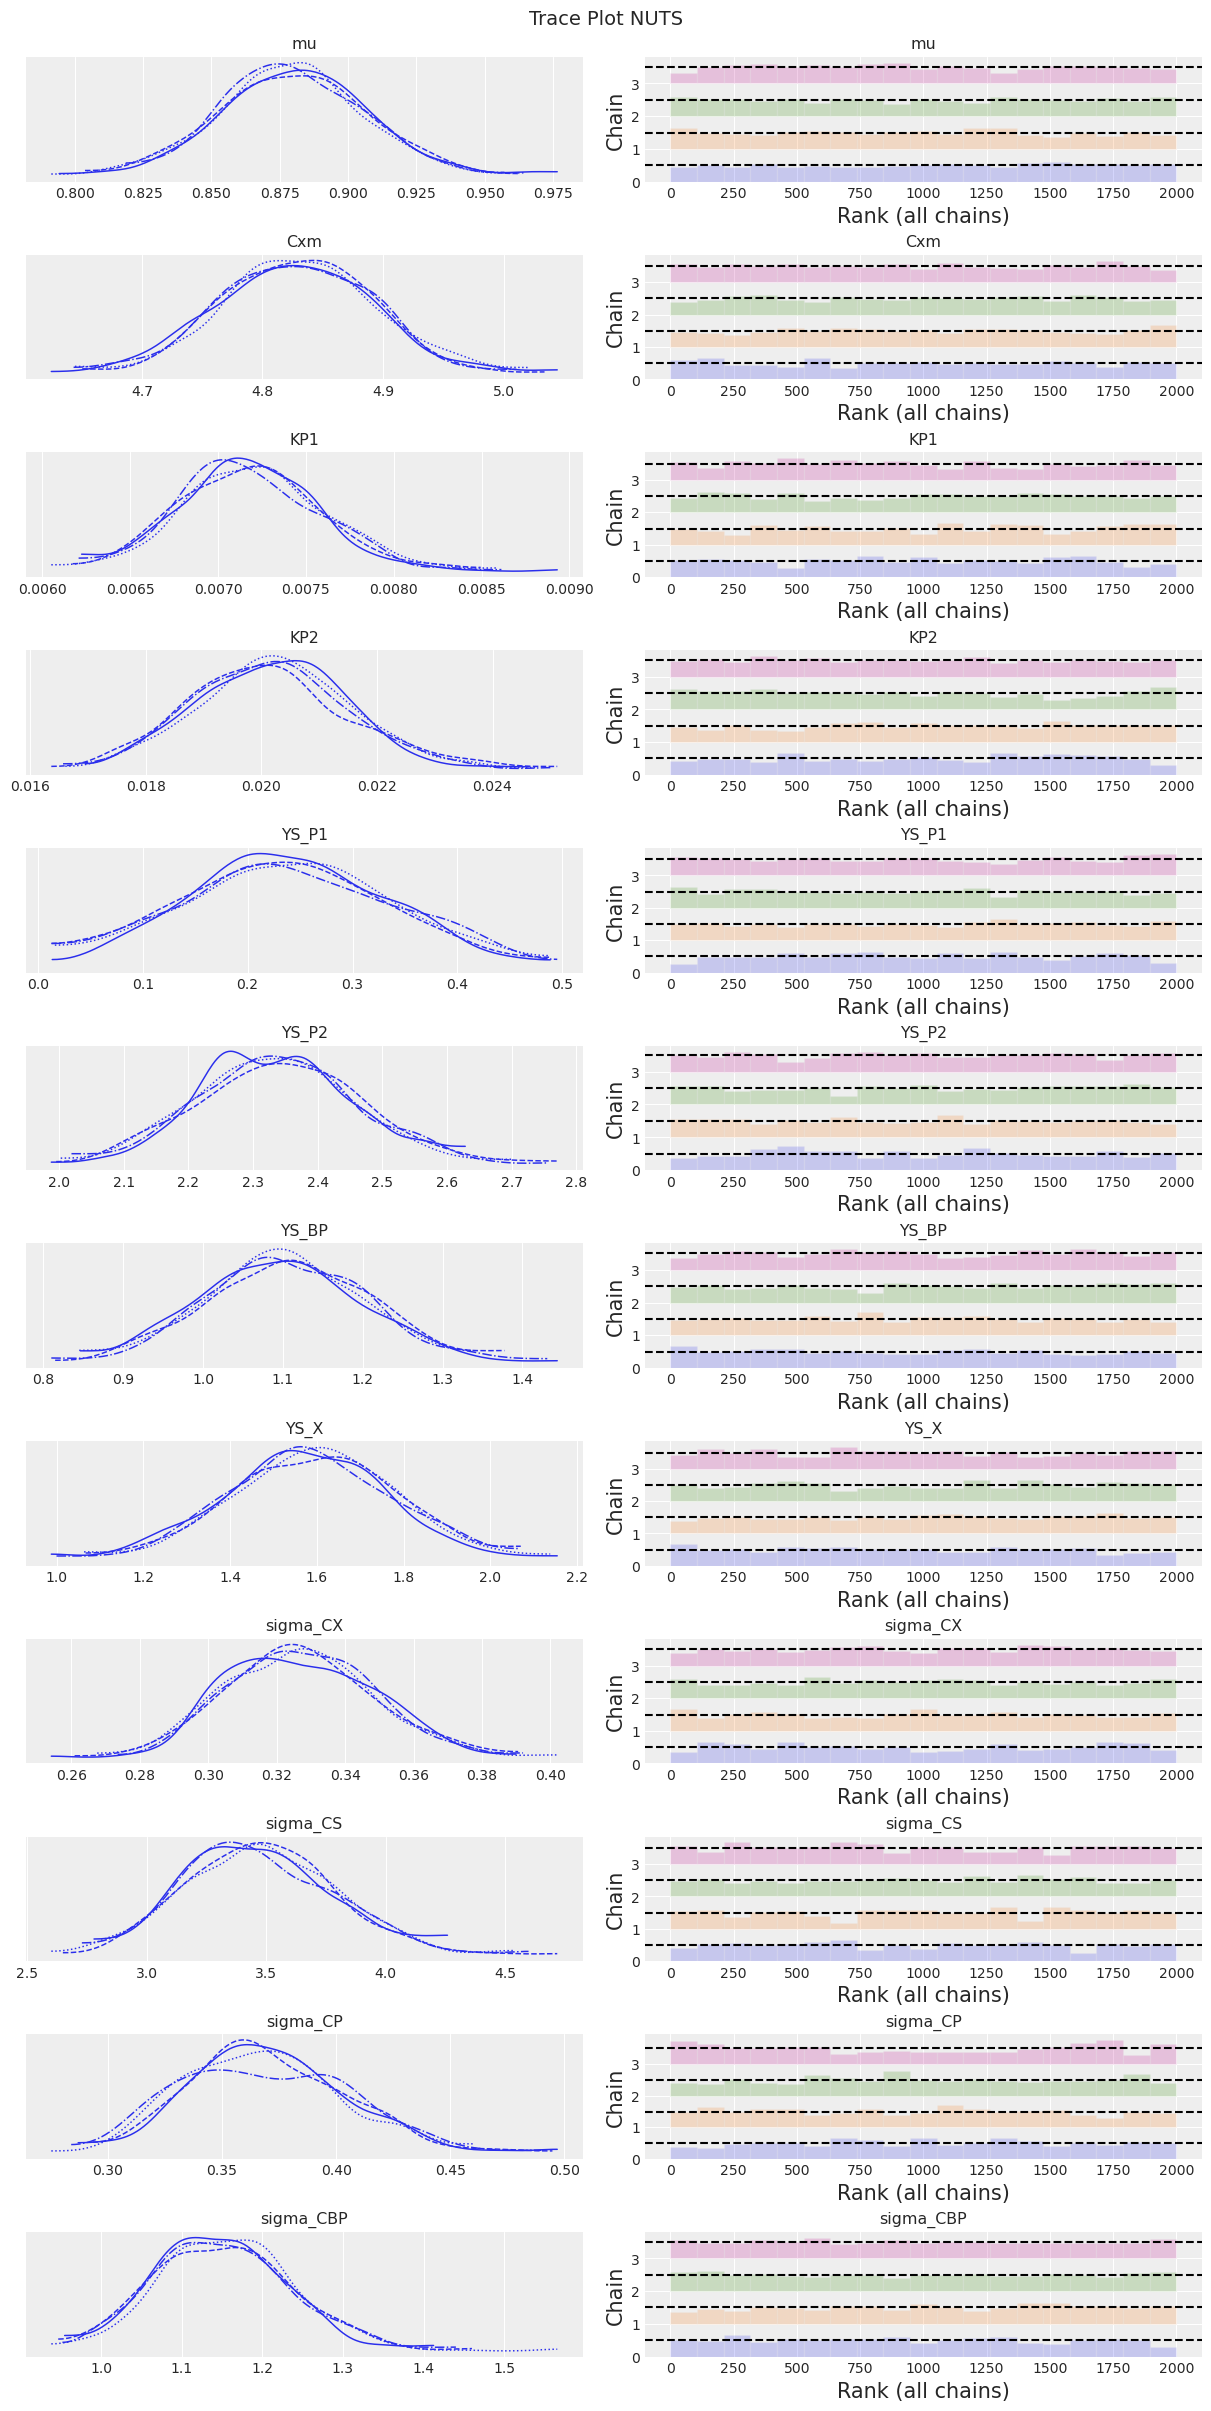

In [21]:
az.style.use("arviz-darkgrid")

az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}", fontsize=14)
plt.show()

In [22]:
az.style.use("default")

def plot_data(ax, lw=2, title="Fermentation Process Data"):
    ax.plot(experiment_data['time'], experiment_data['Biomass (X)'], color='g', lw=lw, marker='D', label='Biomass (Data)', markersize=5)
    ax.plot(experiment_data['time'], experiment_data['Glucose (G)'], color='b', lw=lw, marker='s', label='Glucose (Data)', markersize=6)
    ax.plot(experiment_data['time'], experiment_data['Succinic Acid (SA)'], color='r', lw=lw, marker='o', label='Succinic Acid (Data)', markersize=5)
    ax.plot(experiment_data['time'], experiment_data['By-Products (BP)'], color='orange', lw=lw, marker='>', label='By-Products (Data)', markersize=6)
    ax.legend(fontsize=12, loc="upper right")
    ax.set_xlim([experiment_data['time'].min(), experiment_data['time'].max()])
    ax.set_ylim(0)
    ax.set_xlabel("Time (hours)", fontsize=14)
    ax.set_ylabel("Concentration (g/L)", fontsize=14)
    ax.set_xticks(experiment_data['time'])
    ax.set_xticklabels(experiment_data['time'].astype(int), fontsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title(title, fontsize=15)
    return ax


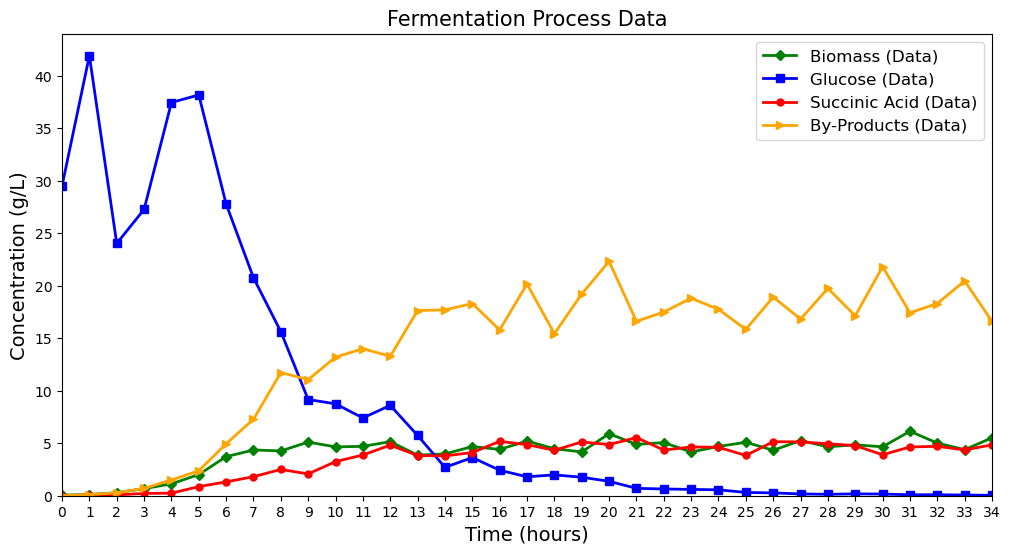

In [23]:
_, ax = plt.subplots(figsize=(12, 6))
plot_data(ax);

In [24]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    # Extract parameter names and values
    cols = ["mu", "Cxm", "KP1", "KP2", "YS_P1", "YS_P2", "YS_BP", "YS_X"]
    row = trace_df.iloc[row_idx, :][cols].values

    # Create a SympyProblem instance
    problem = sunode.SympyProblem(
        params=params,
        states=states,
        rhs_sympy=sunode_rhs,
        derivative_params=(),
    )

    # Initialize solver with BDF method 
    solver = sunode.solver.Solver(problem=problem, solver='BDF')

    # Set initial conditions
    y0 = np.zeros((), dtype=problem.state_dtype)
    y0['CX'] = 0.05
    y0['CS'] = 40.0
    y0['CP'] = 0.0
    y0['CBP'] = 0.0

    # Convert array to dictionary with correct parameter names
    params_values = {
        'mu': row[0],
        'Cxm': row[1],
        'KP1': row[2],
        'KP2': row[3],
        'YS_P1': row[4],
        'YS_P2': row[5],
        'YS_BP': row[6],
        'YS_X': row[7],
        'extra': np.zeros(1),
    }

    times = np.arange(0.0, 35.0, 0.01)
    
    # Set parameter values
    solver.set_params_dict(params_values)

    output = solver.make_output_buffers(times)

    print(f"\nRunning sunode (Run {row_idx+1})...")
    start_time = time.time()
    solution_sunode = solver.solve(t0=0, tvals=times, y0=y0, y_out=output)

    solve_sunode_time = time.time() - start_time
    print(f"sunode completed in {solve_sunode_time:.4f} seconds")
    
    output_sunode = solver.as_xarray(times, output)
    sol_array = np.stack([
        output_sunode['solution_CX'].values, 
        output_sunode['solution_CS'].values, 
        output_sunode['solution_CP'].values, 
        output_sunode['solution_CBP'].values
    ], axis=1)

    # Plotting
    colors = ['green', 'blue', 'red', 'orange']
    
    for i in range(4):
        ax.plot(times, sol_array[:, i], color=colors[i], lw=lw, alpha=alpha)
    
    return ax


In [25]:
def plot_inference(ax, trace, num_samples=25, title="Fermentation Process: Data and\nInference Model Runs", plot_model_kwargs=dict(lw=1, alpha=0.2)):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    
    handles, labels = ax.get_legend_handles_labels()
    seen_labels = set()
    unique_handles = []
    unique_labels = []
    
    for handle, label in zip(handles, labels):
        base_label = label.split(' (')[0]
        if base_label not in seen_labels:
            seen_labels.add(base_label)
            unique_handles.append(handle)
            unique_labels.append(label)
    
    ax.legend(unique_handles, unique_labels, fontsize=12, loc="upper right")
    ax.set_title(title, fontsize=15)


Running sunode (Run 1)...
sunode completed in 0.0035 seconds

Running sunode (Run 2)...
sunode completed in 0.0035 seconds

Running sunode (Run 3)...
sunode completed in 0.0037 seconds

Running sunode (Run 4)...
sunode completed in 0.0042 seconds

Running sunode (Run 5)...
sunode completed in 0.0035 seconds

Running sunode (Run 6)...
sunode completed in 0.0036 seconds

Running sunode (Run 7)...
sunode completed in 0.0039 seconds

Running sunode (Run 8)...
sunode completed in 0.0037 seconds

Running sunode (Run 9)...
sunode completed in 0.0036 seconds

Running sunode (Run 10)...
sunode completed in 0.0040 seconds

Running sunode (Run 11)...
sunode completed in 0.0037 seconds

Running sunode (Run 12)...
sunode completed in 0.0039 seconds

Running sunode (Run 13)...
sunode completed in 0.0036 seconds

Running sunode (Run 14)...
sunode completed in 0.0038 seconds

Running sunode (Run 15)...
sunode completed in 0.0040 seconds

Running sunode (Run 16)...
sunode completed in 0.0036 seconds



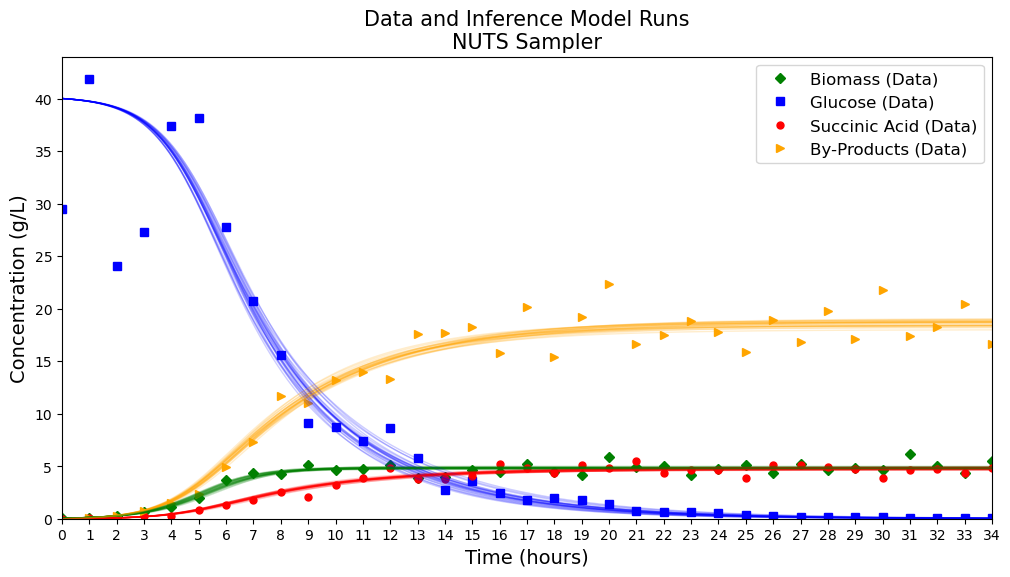

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");